Practica NLP

Analisis de sentimiento en reviews de Amazon Electronics
El objetivo de este proyecto es desarrollar un sistema de analisis de sentimiento a partir de reviews de productos de Amazon con el dataset seleccionado correpondiente a la categoria de Electronics (5-core) el cual contiene calificacion de estrellas para plantear el problema con un clasificacion supervisada de sentimiento.

Descarga y exploracion del corpus

In [43]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("default")
sns.set_theme()
df = pd.read_json(
    "reviews_Electronics_5.json.gz",
    lines=True,
)
df.shape
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   reviewerID      1689188 non-null  object
 1   asin            1689188 non-null  object
 2   reviewerName    1664458 non-null  object
 3   helpful         1689188 non-null  object
 4   reviewText      1689188 non-null  object
 5   overall         1689188 non-null  int64 
 6   summary         1689188 non-null  object
 7   unixReviewTime  1689188 non-null  int64 
 8   reviewTime      1689188 non-null  object
dtypes: int64(2), object(7)
memory usage: 116.0+ MB


El dataset contiene 1.689.188 reviews de productos electronicos de Amazon estan incluidos las calificaciones en estrellas y metadatos de ususarios y productos, no se observan valores nulos.

Subsets

In [44]:
df_sample = df.sample(n=50000, random_state=42)
df_sample.shape
del df 

Grafico de distribucion de estrellas 

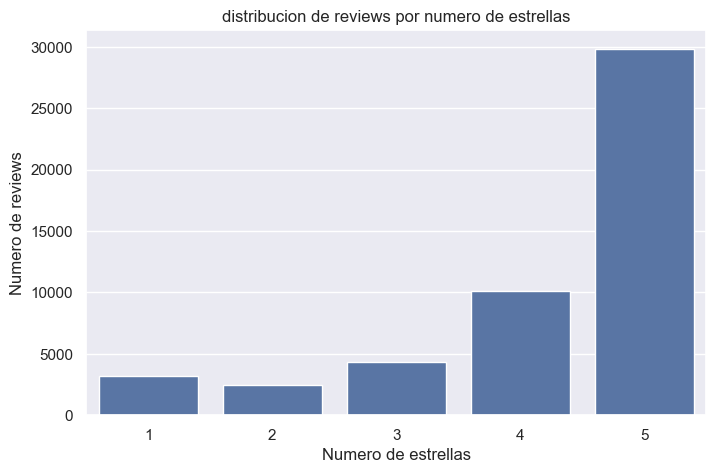

In [45]:
plt.figure(figsize=(8,5))
sns.countplot(
    x="overall",
    data=df_sample,
    order=sorted(df_sample["overall"].unique())
)
plt.title("distribucion de reviews por numero de estrellas")
plt.xlabel("Numero de estrellas")
plt.ylabel("Numero de reviews")
plt.show()


El histograma muestra las calificaciones destacandose las 4 y 5 estrellas como las mas frecuentes lo que nos dicen que la mayoria de valoraciones son positivas.

variables de sentimientos

In [46]:
df_sentiment = df_sample.copy()
df_sentiment = df_sentiment[df_sentiment["overall"] != 3]
df_sentiment["sentiment"] = df_sentiment["overall"].apply(
    lambda x: 1 if x >= 4 else 0
)
df_sentiment["sentiment"].value_counts()


sentiment
1    40016
0     5683
Name: count, dtype: int64

Visualizacion de variable de sentimientos

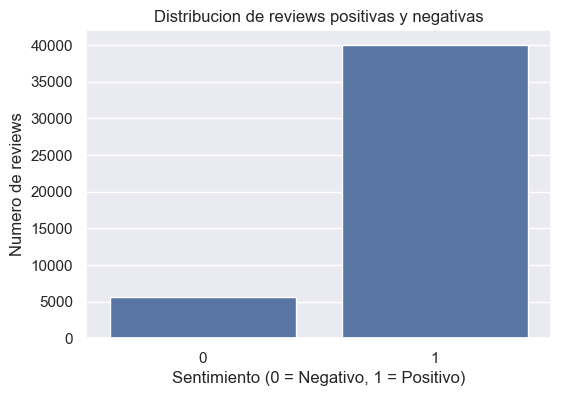

In [47]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=df_sentiment)
plt.title("Distribucion de reviews positivas y negativas")
plt.xlabel("Sentimiento (0 = Negativo, 1 = Positivo)")
plt.ylabel("Numero de reviews")
plt.show()

Se elimnaron las reviews de 3 estrellas por considerarse ambiguas, se observa un mayor numero de reviews positivas que negativas.

Limpieza y tokenizacion

In [48]:
import re
from collections import Counter
def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    return tokens
tokens_list = df_sentiment["reviewText"].apply(simple_tokenize)
all_tokens = [token for tokens in tokens_list for token in tokens]
vocab = set(all_tokens)
len(vocab)

100303

Palabras mas frecuentes

In [49]:
word_freq = Counter(all_tokens)
word_freq.most_common(20)

[('the', 269949),
 ('i', 143388),
 ('and', 142252),
 ('to', 139648),
 ('a', 135696),
 ('it', 112243),
 ('is', 86731),
 ('of', 72318),
 ('this', 72238),
 ('for', 69420),
 ('my', 55657),
 ('with', 54386),
 ('in', 53428),
 ('that', 52271),
 ('on', 46709),
 ('you', 46379),
 ('have', 40351),
 ('but', 37373),
 ('not', 34657),
 ('was', 31205)]

Se observa cardinalidad del vocabulario muy elevada por ser todas opiniones libres y en la frecuencia de palabras se observa terminos comunes del ingles.

Unigramas

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_uni = CountVectorizer(
    stop_words="english",
    max_features=20
)
X_uni = vectorizer_uni.fit_transform(df_sentiment["reviewText"])
unigrams = vectorizer_uni.get_feature_names_out()
unigram_freq = X_uni.toarray().sum(axis=0)
df_unigrams = pd.DataFrame({
    "unigram": unigrams,
    "frequency": unigram_freq
}).sort_values(by="frequency", ascending=False)
df_unigrams

,unigram,frequency
16,use,19327
7,great,18567
8,just,17386
6,good,16475
9,like,15981
19,works,11380
2,camera,11220
3,case,10761
12,quality,10371
10,price,9800


Grafico de los unigramas

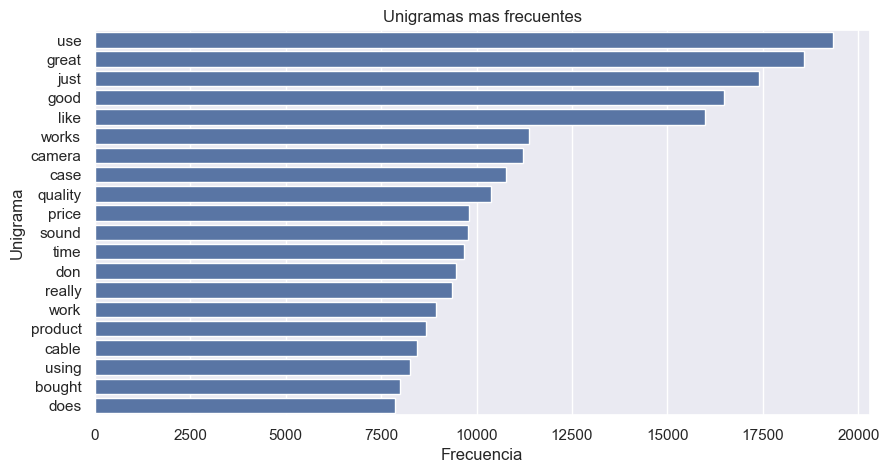

In [51]:
plt.figure(figsize=(10,5))
sns.barplot(x="frequency", y="unigram", data=df_unigrams)
plt.title("Unigramas mas frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Unigrama")
plt.show()

Bigramas

In [52]:
vectorizer_bi = CountVectorizer(
    stop_words="english",
    ngram_range=(2,2),
    max_features=20
)
X_bi = vectorizer_bi.fit_transform(df_sentiment["reviewText"])
bigrams = vectorizer_bi.get_feature_names_out()
bigram_freq = X_bi.toarray().sum(axis=0)
df_bigrams = pd.DataFrame({
    "bigram": bigrams,
    "frequency":bigram_freq
}).sort_values(by="frequency", ascending=False)
df_bigrams

,bigram,frequency
19,works great,2491
7,hard drive,1589
15,sound quality,1589
9,highly recommend,1363
3,easy use,1266
0,battery life,1188
11,make sure,956
2,don know,942
10,just fine,920
1,blu ray,895


Visualizacion de bigramas

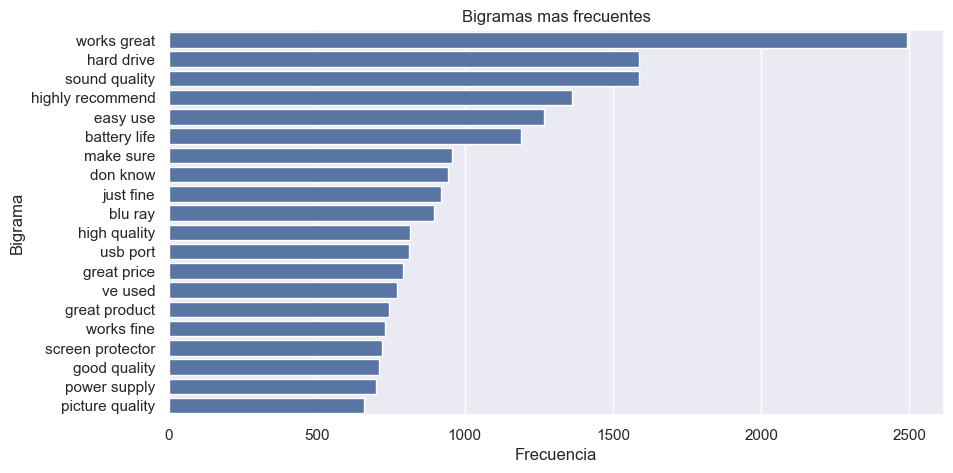

In [53]:
plt.figure(figsize=(10,5))
sns.barplot(x="frequency", y="bigram", data=df_bigrams)
plt.title("Bigramas mas frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Bigrama")
plt.show()

Se observa que los patrones mas frecuentes son los positivos en concordancia con la tendencia que se sigue mostrandonos las expresiones mas informativas en relacion con la calidad, el funcionamiento y la experiencia con los productos electronicos.

Nube de palabras

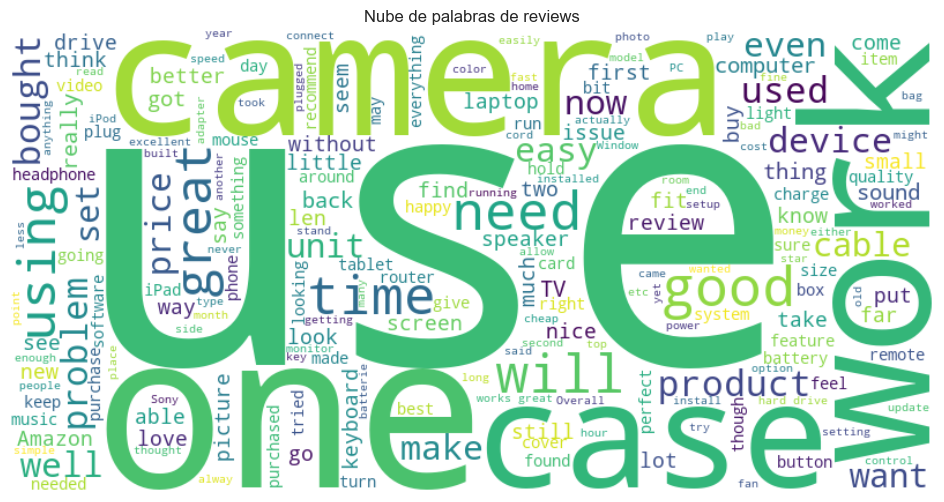

In [54]:
from wordcloud import WordCloud, STOPWORDS
text = " ".join(df_sentiment["reviewText"].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white",
stopwords=STOPWORDS).generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de reviews")
plt.show()

Se observan los terminos mas frecuentes en las reviews relacionados con la calidad, le funcionamiento y la experiencia con los producto electronicos. 

Word Embeddings con Word2Vec

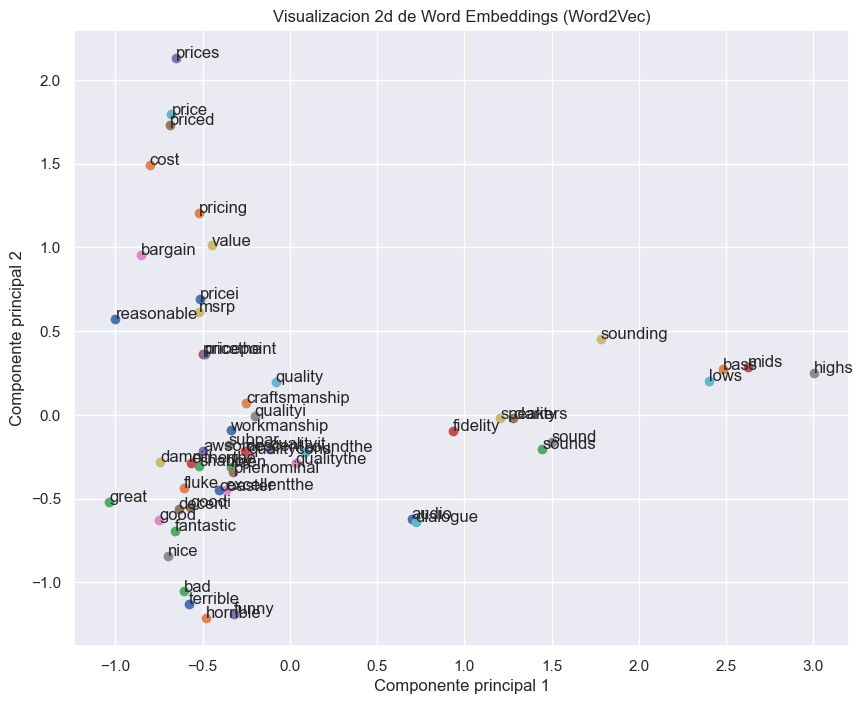

In [55]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
sentences = (
    df_sentiment["reviewText"]
    .str.lower()
    .str.replace(r"[^a-z\s]", "", regex=True)
    .apply(lambda x: x.split())
)
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1
)
target_words = ["good", "bad", "quality", "price", "sound"]
words = []
for word in target_words:
    if word in w2v_model.wv:
        words.append(word)
        similar_words = w2v_model.wv.most_similar(word, topn=10)
        words.extend([w for w, _ in similar_words])
words = list(set(words))
vectors = np.array([w2v_model.wv[word] for word in words])
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)
plt.figure(figsize=(10, 8))
for i, word in enumerate(words):
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1])
    plt.annotate(word, (vectors_2d[i,0], vectors_2d[i, 1]))
plt.title("Visualizacion 2d de Word Embeddings (Word2Vec)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.show()


La visualizacion muestra como palabras con significado semantico similar tienden a agruparse en el espacio vectorial, valoraciones positivas y negativas aparecen cercanos entre si.

Preprocesado de texto

In [56]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)
df_sentiment["review_clean"] = df_sentiment["reviewText"].apply(preprocess_text)
df_sentiment[["reviewText", "review_clean"]].head()

,reviewText,review_clean
981956,"Well, after trying out some Box Towers....that...",well trying box towersthat sounded like music ...
615465,I ordered one for my wife and one for me. Afte...,ordered one wife one reading negative review p...
1060045,muy buen producto... a full en juegos fHD.... ...,muy buen producto full en juegos fhd hay probl...
248321,The sound quality of this unit is phenomenal. ...,sound quality unit phenomenal bose sounddock i...
1498033,It is good on keeping your cpu cool also down'...,good keeping cpu cool also downt forget downlo...


Se paso a minusculas, se elimino caracteres no alfabeticos,se tokenizo, se elimino stowords, se lematizo y se devolvio texto limpio.

Entrenamiento de modelos de analisis de sentimiento

Vectorizacion

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
X = df_sentiment["review_clean"]
y = df_sentiment["sentiment"]
vectorizer = CountVectorizer(
    max_features=5000,
    min_df=5,
    stop_words="english"
)
X_bow = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)

Modelo Naive Bayes

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes")
print(classification_report(y_test, y_pred_nb))

Naive Bayes
              precision    recall  f1-score   support

           0       0.56      0.65      0.60      1137
           1       0.95      0.93      0.94      8003

    accuracy                           0.89      9140
   macro avg       0.76      0.79      0.77      9140
weighted avg       0.90      0.89      0.90      9140



Modelo logistic regression

In [60]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))


Logistic Regression
              precision    recall  f1-score   support

           0       0.52      0.74      0.61      1137
           1       0.96      0.90      0.93      8003

    accuracy                           0.88      9140
   macro avg       0.74      0.82      0.77      9140
weighted avg       0.91      0.88      0.89      9140



Segun los resultado de ambos modelos el rendimiento de accuracy global es muy similar. Sin embargo el modelo de regresion logistica muestra un mejor recall en la clase negativa lo cual ofrece un mejor equilibrio entre precision y capacidad de deteccion de reviews negativas por lo que es el modelo seleccionado.